In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
! pip install emoji
import emoji

# some NLP libraries that can help us with preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')

! pip install tweet_preprocessor
import preprocessor as tweet_preprocessor
! pip install twitter-text-python
from ttp import ttp
! pip install emoji
import emoji
import torch

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LoG1c\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LoG1c\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data = pd.read_csv('./data.csv')

In [3]:
def convert_to_emoji(text):
    return emoji.demojize(text)

In [4]:
tweets = data['tweet']
tweets_tokenized = []
tt = nltk.tokenize.TweetTokenizer()
for tweet in tweets:
    tweet = convert_to_emoji(tweet)
    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~"'?'''
 
    # Removing punctuations in string
    # Using loop + punctuation string
    for ele in tweet:
        if ele in punc:
            tweet = tweet.replace(ele, "")
 
    tweets_tokenized.append(tt.tokenize(text=tweet))

In [5]:
#remove stopwords
stemmer = nltk.stem.porter.PorterStemmer()
stoplist = nltk.corpus.stopwords.words('english')

stemmed = []

for tweet in tweets_tokenized:
    processed_tokens = [stemmer.stem(t) for t in tweet if t not in stoplist]
    stemmed.append(processed_tokens)

In [6]:
def super_simple_preprocess(text):
  # lowercase
  text = text.lower()
  # remove non alphanumeric characters
  text = re.sub('[^A-Za-z0-9 ]+','', text)
  return text

In [7]:
data_updated = []
for tweet in stemmed:
    data_updated.append(super_simple_preprocess(" ".join(tweet)))
pd.DataFrame(data_updated).shape

(10600, 1)

In [8]:
data_updated = pd.DataFrame(data_updated)
data_updated.insert(1, 'w', data['label'])
data = data_updated

In [9]:
data.head()

,0,w
0,the cdc current report 99031 death in gener di...,real
1,state report 1121 death small rise last tuesda...,real
2,polit correct woman almost use pandem excus no...,fake
3,indiafightscorona we 1524 covid test laborator...,real
4,popul state gener larg case count look new cas...,real


In [10]:
sentences = data.iloc[:, 0]

In [11]:
labels = data['w']

In [12]:
labels.replace('real',1, inplace=True)
labels.replace('fake',0, inplace=True)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sentences)

In [14]:
X = X.toarray()

In [15]:
y = labels

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
print("Train : ", len(X_train),"Test : ", len(X_test),"Val : ", len(X_val))

Train :  8480 Test :  1060 Val :  1060


In [17]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train.values)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test.values)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val.values)


In [18]:
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# Define neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
# Instantiate model, loss, and optimizer
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\LoG1c\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
# Define DataLoader
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [22]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_val)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_val).sum().item() / len(y_val)
    print(f'Accuracy: {accuracy}')

Accuracy: 0.9433962264150944


In [67]:
import fasttext

In [68]:
data = pd.read_csv('./data.csv')

In [140]:
labels = data['label']

In [141]:
labels.replace('real',1, inplace=True)
labels.replace('fake',0, inplace=True)

In [71]:
data['combined'] = "__label__" + data['label'].astype(str) + " " + data['tweet'].astype(str)
data

,tweet,label,combined
0,The CDC currently reports 99031 deaths. In gen...,1,__label__1 The CDC currently reports 99031 dea...
1,States reported 1121 deaths a small rise from ...,1,__label__1 States reported 1121 deaths a small...
2,Politically Correct Woman (Almost) Uses Pandem...,0,__label__0 Politically Correct Woman (Almost) ...
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1,__label__1 #IndiaFightsCorona: We have 1524 #C...
4,Populous states can generate large case counts...,1,__label__1 Populous states can generate large ...
...,...,...,...
10595,RT @Surgeon_General: There are simple actions ...,1,__label__1 RT @Surgeon_General: There are simp...
10596,@explicitgrande @ftwrharry @wolfiecindy You we...,0,__label__0 @explicitgrande @ftwrharry @wolfiec...
10597,We continue to progress our contact with the p...,1,__label__1 We continue to progress our contact...
10598,"""Wrong"" COVID-19 case count by Orlando Health ...",0,"__label__0 ""Wrong"" COVID-19 case count by Orla..."


In [72]:
train, test = train_test_split(data, test_size=0.2)

In [73]:
test, val = train_test_split(test, test_size=0.5)

In [74]:
train.to_csv('data.train', columns=['combined'], index=False, header=False)
test.to_csv('data.test', columns=['combined'], index=False, header=False)
val.to_csv('data.val', columns=['combined'], index=False, header=False)

In [75]:
model = fasttext.train_supervised(input='data.train')
model.test('data.test')

(904, 0.952433628318584, 0.952433628318584)

In [76]:
model.save_model(path='./model.bin')

In [77]:
# Load the pre-trained FastText model
fasttext_model = fasttext.load_model('./model.bin')

In [78]:
# Tokenize input sentences
tokenized_sentences = [sentence.split() for sentence in sentences]

In [79]:
# Determine the maximum input length
max_inp_len = max(len(tokens) for tokens in tokenized_sentences)

In [80]:
# Dimension of FastText embeddings
d = fasttext_model.get_dimension()

In [81]:
# Initialize matrix with zeros
matrix = np.zeros((len(sentences), max_inp_len, d), dtype=np.float32)

In [82]:
# Fill the matrix with FastText embeddings
for i, tokens in enumerate(tokenized_sentences):
    for j, token in enumerate(tokens):
        matrix[i, j] = fasttext_model[token]

In [134]:
matrix.shape

(10600, 1064, 100)

In [142]:
train_matrix = matrix[:8480, :, :]
test_matrix = matrix[9540:, :, :]
val_matrix = matrix[8480 : 9540, :, :]
train_labels = labels[:8480]
test_labels = labels[9540:]
val_labels = labels[8480 : 9540]

In [143]:
train_matrix.shape

(8480, 1064, 100)

In [144]:
labels.shape

(10600,)

In [145]:
train_matrix.shape, test_matrix.shape, train_labels.shape, test_labels.shape, val_matrix.shape, val_labels.shape

((8480, 1064, 100),
 (1060, 1064, 100),
 (8480,),
 (1060,),
 (1060, 1064, 100),
 (1060,))

In [146]:
train_matrix = pd.DataFrame(train_matrix.reshape(-1,106400))
test_matrix = pd.DataFrame(test_matrix.reshape(-1, 106400))
val_matrix = pd.DataFrame(val_matrix.reshape(-1, 106400))
train_labels = pd.DataFrame(train_labels)
test_labels = pd.DataFrame(test_labels)
val_labels = pd.DataFrame(val_labels)

In [147]:
train_labels.head()

,label
0,1
1,1
2,0
3,1
4,1


In [148]:
# If you're using PyTorch, you can create a custom dataset to handle this
class CustomDataset(Dataset):
    def __init__(self, matrix, labels):
        self.x = torch.tensor(matrix.values, dtype=torch.float32).reshape(-1,1,106400)
        self.y = torch.tensor(labels.values, dtype=torch.long).reshape(-1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


train_dataset = CustomDataset(train_matrix, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(val_matrix, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = CustomDataset(test_matrix, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [149]:
for x,y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 106400]) torch.Size([32])


In [150]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [151]:
class Network(nn.Module):
  def __init__(self, input_channel = 1, output_dim = 2):
    super().__init__()
    self.conv_1 = nn.Conv1d(1, 128, 28, stride = 28)
    self.activation_1 = nn.ReLU()

    self.conv_2 = nn.Conv1d(128, 256, 28, stride = 28)
    self.activation_2 = nn.ReLU()

    self.flatten = nn.Flatten()

    self.linear_3 = nn.Linear(34560, output_dim)

  def forward(self, x):
    out = self.conv_1(x)
    out = self.activation_1(out)

    out = self.conv_2(out)
    out = self.activation_2(out)

    out = self.flatten(out)

    out = self.linear_3(out)

    return out

In [152]:
network = Network().to(device)

In [153]:
from torchsummary import summary
summary(network, (1, 106400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 3800]           3,712
              ReLU-2            [-1, 128, 3800]               0
            Conv1d-3             [-1, 256, 135]         917,760
              ReLU-4             [-1, 256, 135]               0
           Flatten-5                [-1, 34560]               0
            Linear-6                    [-1, 2]          69,122
Total params: 990,594
Trainable params: 990,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.41
Forward/backward pass size (MB): 8.21
Params size (MB): 3.78
Estimated Total Size (MB): 12.40
----------------------------------------------------------------


In [154]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(network.parameters(), lr = 0.001)
epochs = 10

In [155]:
train_epoch_loss = []
eval_epoch_loss = []

In [156]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [157]:
for epoch in tqdm(range(epochs)):
    curr_loss = 0
    total = 0
    for train_x, train_y in train_dataloader:
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        optim.zero_grad()

        y_pred = network(train_x)
        loss = criterion(y_pred, train_y)

        loss.backward()
        optim.step()

        curr_loss += loss.item()
        total += len(train_y)
    train_epoch_loss.append(curr_loss / total)

    curr_loss = 0
    total = 0
    for eval_x, eval_y in val_dataloader:
        eval_x = eval_x.to(device)
        eval_y = eval_y.to(device)
        optim.zero_grad()

        with torch.no_grad():
            y_pred = network(eval_x)

        loss = criterion(y_pred, eval_y)

        curr_loss += loss.item()
        total += len(train_y)
    eval_epoch_loss.append(curr_loss / total)

100%|██████████| 10/10 [01:26<00:00,  8.63s/it]


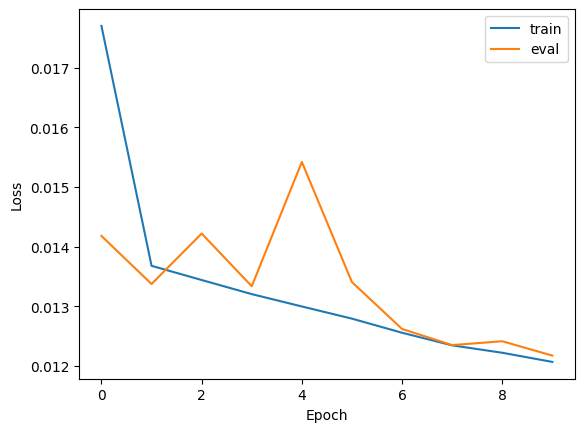

In [158]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch_loss, label='train')
plt.plot(range(epochs), eval_epoch_loss, label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [159]:
correct = 0
total = 0
for x, y in test_dataloader:
    x = x.to(device)
    with torch.no_grad():
        yp = network(x)
    yp = torch.argmax(yp.cpu(), dim = 1)
    correct += (yp == y).sum()
    total += len(y)
print(f"Accuracy on Test Data {(correct * 100 / total):.2f}")

Accuracy on Test Data 81.79
